In [1]:
import sys
import os

import numpy as np
from numpy import random
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
%matplotlib inline
from tqdm import tqdm_notebook

PARENT_DIR = os.path.realpath('..')
import importlib
if PARENT_DIR not in sys.path:
    sys.path.append(PARENT_DIR)

try: importlib.reload(sl)
except: import synt_lib as sl

In [2]:
DIRS = sl.get_dirs(parent_dir=PARENT_DIR)
M_PARAMS = sl.get_model_params()

In [3]:
quant = M_PARAMS['QUANTIZATION_CHANNELS']
nbits = int(np.log2(quant))

# Build model

# Get Data

Всего файлов:
* Обучение (cv-valid-train): 391552
* cv-valid-dev: 8152
* cv-valid-test: 7990

In [4]:
full_ds = pd.concat([pd.read_csv(DIRS['MANIFESTS']+f, header=None) for f in os.listdir(DIRS['MANIFESTS'])])
full_ds.columns = ['wav','txt','dur']

In [5]:
for c in ['wav','txt']:
    full_ds[c] = full_ds[c].apply(lambda f: f.replace('../data/ru_open_stt',DIRS['RAW_DATA']+'rus'))

In [6]:
full_ds['wav_exist'] = full_ds['wav'].apply(lambda f: os.path.isfile(f) if type(f)==str else False)
full_ds['txt_exist'] = full_ds['txt'].apply(lambda f: os.path.isfile(f) if type(f)==str else False)

In [7]:
to_train_ds = full_ds[(full_ds['wav_exist'])]#&(full_ds['txt_exist'])]

In [8]:
to_train_ds.shape, to_train_ds.shape[0]/full_ds.shape[0]

((2, 5), 1.1482124055164716e-06)

In [9]:
to_train_ds.shape, to_train_ds.shape[0]/full_ds.shape[0]

((2, 5), 1.1482124055164716e-06)

# Develop models

## DocToVec

## WaveGRU

In [10]:
import DWave4
DWave4 = importlib.reload(DWave4)

In [11]:
vars_to_restore = ['M_IrV','M_IuV','M_IeV', 'Ir','Iu','Ie',
 'Rr','Ru','Re','M_RrV','M_RuV','M_ReV',
 'O1','O2','O3','O4','M_O1V','M_O2V','M_O3V','M_O4V',
 'br','bu','be','bO1','bO2','bO3','bO4',
 ]
vars_to_restore = [x+':0' for x in vars_to_restore]

In [12]:
model_name = "final1_256"

In [13]:
from datetime import datetime

In [14]:
wav_fnames = list(to_train_ds['wav'])
text_fnames = list(to_train_ds['txt'])

In [15]:
wav_fnames = wav_fnames*500

In [16]:
save_period = 500

In [17]:
from datetime import datetime

In [18]:
log_fname = DIRS['NOTEBOOKS']+'logger'

In [22]:
n_epochs = min(len(wav_fnames), 250000)
#inferred_texts = [doc2vec.infer_vector(t.split()) for t in texts[:n_epochs]]
sparsity_epochs = np.arange(1000, n_epochs, 500)
#sparsity_epochs = (np.linspace(0.50, 0.95, 20)*n_epochs).astype(int)

n_epochs

1000

In [124]:
len(sparsity_epochs)

0

In [23]:
(255-128)/128

0.9921875

In [24]:
max_val = (255-128)/128

In [25]:
#saver = tf.train.import_meta_graph(DIRS['MODELS']+model_name+'/final.meta')
#saver = tf.train.import_meta_graph(DIRS['MODELS']+model_name+'/checkpoint-4000.meta')
#saver.restore(sess,tf.train.latest_checkpoint(DIRS['MODELS']+model_name))
#restored_variables = {x.name:x.eval(session=sess) for x in tf.global_variables() if x.name in WaveGRU.vars_to_restore}
restored_variables=None
tf.reset_default_graph()
with tf.device('CPU'):
    gru = DWave4.WaveGRU(3, 64, n_batches=1, restore_variables=restored_variables, hidden_size=1024)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [26]:
%%time
audios = [sess.run(sl.load_data([wav_fnames[i]]))[0] for i in range(min(100, len(wav_fnames)))]

Instructions for updating:
Use tf.cast instead.
CPU times: user 14.1 s, sys: 739 ms, total: 14.8 s
Wall time: 14.3 s


In [27]:
n_batches = 1 # gru.n_batches
audios = [np.concatenate([audio, [[max_val,max_val]]*(2*n_batches-audio.shape[0]%n_batches)]) for audio in audios]
audios = [np.concatenate([[[-1,-1]]*n_batches,audio]) for audio in audios]
audios = [audio.reshape((n_batches, -1, gru.input_dim-1)) for audio in audios]

In [31]:
audio_resh = audios[0]

In [33]:
audio_resh.shape

(1, 15682, 2)

In [34]:
audio_resh = audio_resh

In [36]:
audio_resh = np.concatenate([audio_resh for i in range(gru.n_batches)])

In [51]:
txt_emb = np.zeros((1,gru.text_embed_size))

In [53]:
saver = tf.train.Saver()

In [91]:
n_epochs = 100
sparsity_lvl = 0.9

In [63]:
#start_epoch = epoch #= 0


In [309]:
devices_var = ['CPU','GPU']
batches_var = [1,5,10,15,20,25,30,35]
hsize_var = [128, 256, 1024, 2048, 4048]

In [111]:
from itertools import product

In [312]:
old_res_ds.index = old_res_ds['index_in_row']

In [315]:
res_dss = [old_res_ds]
for idx, var in enumerate(product(devices_var, batches_var, hsize_var)):
    device, n_batches, hidden_size = var
    
    cds = pd.concat(res_dss)[['device','n_batches','hidden_size']].drop_duplicates()
    cds = cds[(cds['device']==device)&(cds['n_batches']==n_batches)&(cds['hidden_size']==hidden_size)].drop_duplicates()
    if cds.shape[0]>0:
        print(device, n_batches, hidden_size, 'already calculated')
        continue
    if device=='CPU' and hidden_size>1024:
        print(device, n_batches, hidden_size, 'to much hidden_size to CPU. skipping')
        continue
    print('at {idx} iteration ({var})'.format(idx=idx, var=var))
        
    start_epoch  = 0
    gru_losses = []
    start_learn = datetime.now()
    gru_times = []
    
    try:
        tf.reset_default_graph()
        with tf.device(device):
            gru = DWave4.WaveGRU(3, 64, n_batches=n_batches, restore_variables=None, hidden_size=hidden_size)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        
        audio_resh = audios[0]
        audio_resh = audio_resh[:,:8000,:]
        audio_resh = np.concatenate([audio_resh for i in range(gru.n_batches)])
        sound_X = audio_resh
        sound_Y = sound_X
        c = sound_X[:,:,0]
        c_shift = np.hstack([c, np.zeros((gru.n_batches,1))])[:,1:]
        c_shift = c_shift.reshape(gru.n_batches,-1,1)
        sound_X = np.concatenate([sound_X, c_shift],2)
        txt_emb = np.zeros((1,gru.text_embed_size))
        feed_dict={gru.sound_X:sound_X, gru.txt_embed_plh:txt_emb, gru.Y_true:sound_Y}
        
        for epoch in range(start_epoch, n_epochs):
            _, loss = sess.run([gru.train_step, gru.loss],
                                 feed_dict=feed_dict)
            gru_losses.append(loss)
            gru_times.append(datetime.now())
            
        res_ds = pd.DataFrame()
        res_ds['time'] = gru_times
        res_ds['losses'] = gru_losses
        res_ds['device'] = device
        res_ds['n_batches'] = n_batches
        res_ds['hidden_size'] = hidden_size
        res_dss.append(res_ds)
        pd.concat(res_dss).to_csv('gpu_results.csv')
            
    except Exception as e:
        print('Error at {idx} iteration ({var})'.format(idx=idx, var=var))
        print(e)
    
    
res_ds = pd.concat(res_dss)

CPU 1 128 already calculated
CPU 1 256 already calculated
CPU 1 1024 already calculated
CPU 1 2048 to much hidden_size to CPU. skipping
CPU 1 4048 to much hidden_size to CPU. skipping
CPU 5 128 already calculated
CPU 5 256 already calculated
CPU 5 1024 already calculated
CPU 5 2048 to much hidden_size to CPU. skipping
CPU 5 4048 to much hidden_size to CPU. skipping
CPU 10 128 already calculated
CPU 10 256 already calculated
CPU 10 1024 already calculated
CPU 10 2048 to much hidden_size to CPU. skipping
CPU 10 4048 to much hidden_size to CPU. skipping
at 15 iteration (('CPU', 15, 128))


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """


at 16 iteration (('CPU', 15, 256))
at 17 iteration (('CPU', 15, 1024))
CPU 15 2048 to much hidden_size to CPU. skipping
CPU 15 4048 to much hidden_size to CPU. skipping
at 20 iteration (('CPU', 20, 128))
at 21 iteration (('CPU', 20, 256))
at 22 iteration (('CPU', 20, 1024))
CPU 20 2048 to much hidden_size to CPU. skipping
CPU 20 4048 to much hidden_size to CPU. skipping
at 25 iteration (('CPU', 25, 128))
at 26 iteration (('CPU', 25, 256))
at 27 iteration (('CPU', 25, 1024))
CPU 25 2048 to much hidden_size to CPU. skipping
CPU 25 4048 to much hidden_size to CPU. skipping
at 30 iteration (('CPU', 30, 128))
at 31 iteration (('CPU', 30, 256))
at 32 iteration (('CPU', 30, 1024))
CPU 30 2048 to much hidden_size to CPU. skipping
CPU 30 4048 to much hidden_size to CPU. skipping
at 35 iteration (('CPU', 35, 128))
at 36 iteration (('CPU', 35, 256))
at 37 iteration (('CPU', 35, 1024))
CPU 35 2048 to much hidden_size to CPU. skipping
CPU 35 4048 to much hidden_size to CPU. skipping
GPU 1 128 alrea

at 76 iteration (('GPU', 35, 256))
at 77 iteration (('GPU', 35, 1024))
at 78 iteration (('GPU', 35, 2048))
at 79 iteration (('GPU', 35, 4048))
Error at 79 iteration (('GPU', 35, 4048))
OOM when allocating tensor with shape[8000,35,4048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node h_t_transposed/TensorArrayStack/TensorArrayGatherV3 (defined at /workspace/Dudyrev/Speach_Synthesizer/notebooks/DWave4.py:167) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node Mean (defined at /workspace/Dudyrev/Speach_Synthesizer/notebooks/DWave4.py:135) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'h_t_transposed/TensorArrayStack/TensorArrayGatherV3', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_m

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [11]:
import pandas as pd
res_ds = pd.read_csv('gpu_results.csv',index_col=0, parse_dates=['time'])

In [12]:
res_ds['index_in_row'] = res_ds.index
res_ds.index = range(len(res_ds))

In [14]:
res_ds['time_last'] = res_ds['time'].shift(1)
res_ds.loc[res_ds['index_in_row']==0, 'time_last'] = None
res_ds['time_delta'] = res_ds['time']-res_ds['time_last']
res_ds['time_delta_seconds'] = [x.total_seconds() if x is not pd.NaT else None for x in res_ds['time_delta']]
res_ds.head()

,device,hidden_size,index_in_row,losses,n_batches,time,time_delta,time_delta_seconds,time_last
0,CPU,128,0,5.544853,1,2019-06-21 13:22:47.712704,NaT,NaN,NaT
1,CPU,128,1,5.544168,1,2019-06-21 13:22:50.212251,00:00:02.499547,2.499547,2019-06-21 13:22:47.712704
2,CPU,128,2,5.543474,1,2019-06-21 13:22:52.700275,00:00:02.488024,2.488024,2019-06-21 13:22:50.212251
3,CPU,128,3,5.542737,1,2019-06-21 13:22:55.172457,00:00:02.472182,2.472182,2019-06-21 13:22:52.700275
4,CPU,128,4,5.541954,1,2019-06-21 13:22:57.638142,00:00:02.465685,2.465685,2019-06-21 13:22:55.172457


In [63]:
res_ds.pivot_table(index=['n_batches','hidden_size'], columns='device', values='time_delta_seconds', aggfunc='mean')
cds.loc[(30, 4048), 'GPU'] = None
cds.loc[(35, 4048), 'GPU'] = None
cds = cds.sort_index()
cds

device                       CPU        GPU
n_batches hidden_size                      
1         128           2.492423   6.065356
          256           2.640672   6.119669
          1024          7.218090   7.210800
          2048               NaN   6.265658
          4048               NaN  14.467275
5         128           2.860727   6.867843
          256           4.539716   6.644216
          1024         10.965950   7.014654
          2048               NaN   8.358908
          4048               NaN  16.118331
10        128           3.105973   6.892157
          256           4.793465   6.648471
          1024         13.551868   7.034788
          2048               NaN   8.483124
          4048               NaN  17.621668
15        128           3.314043   6.860026
          256           5.525317   6.611570
          1024         15.883699   7.000434
          2048               NaN   8.570074
          4048               NaN  17.098039
20        128           3.430758   8.099511
          256           6.831302   7.887218
          1024         18.162500   8.042742
          2048               NaN   8.739428
          4048               NaN  17.524181
25        128           3.915094   8.035185
          256           7.359127   7.831255
          1024         20.005586   7.999438
          2048               NaN   8.707288
          4048               NaN  18.239195
30        128           4.319686   8.070227
          256           7.883618   7.844639
          1024         22.573967   8.042557
          2048               NaN   8.788345
          4048               NaN        NaN
35        128           4.695597   8.152973
          256           8.777261   7.998768
          1024         25.388591   8.255810
          2048               NaN   9.577857
          4048               NaN        NaN

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

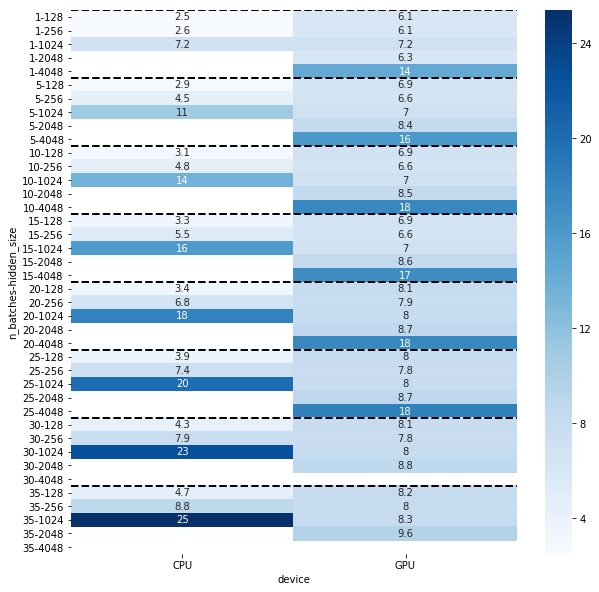

In [60]:
plt.figure(figsize=(10,10))
cds = res_ds.pivot_table(index=['n_batches','hidden_size'], columns='device', values='time_delta_seconds', aggfunc='mean')
cds.loc[(30, 4048), 'GPU'] = None
cds.loc[(35, 4048), 'GPU'] = None
cds = cds.sort_index()
s = (cds.reset_index()['n_batches']!=cds.reset_index()['n_batches'].shift(1)).astype(int)
s = s[s>0].index
sns.heatmap(cds, cmap='Blues', annot=True)
for i in s:
    plt.axhline(i, linestyle='--', color='black', linewidth=2)

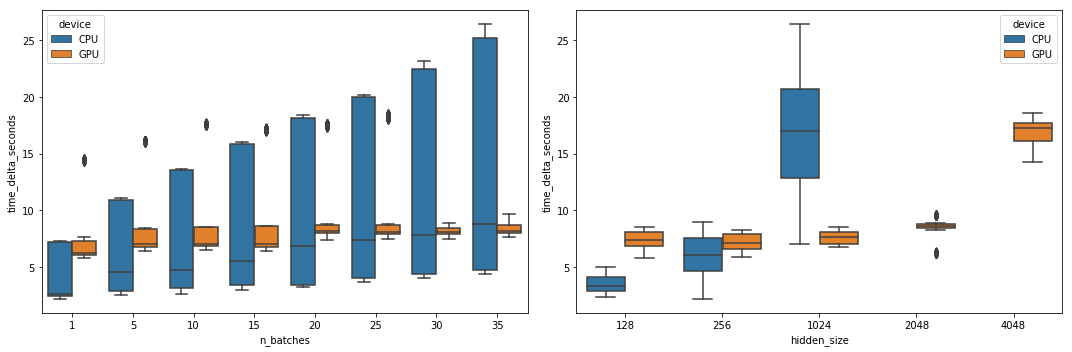

In [64]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(x='n_batches',y='time_delta_seconds',data=res_ds, hue='device')

plt.subplot(122)
sns.boxplot(x='hidden_size', y='time_delta_seconds', data=res_ds, hue='device')

plt.tight_layout()
plt.show()

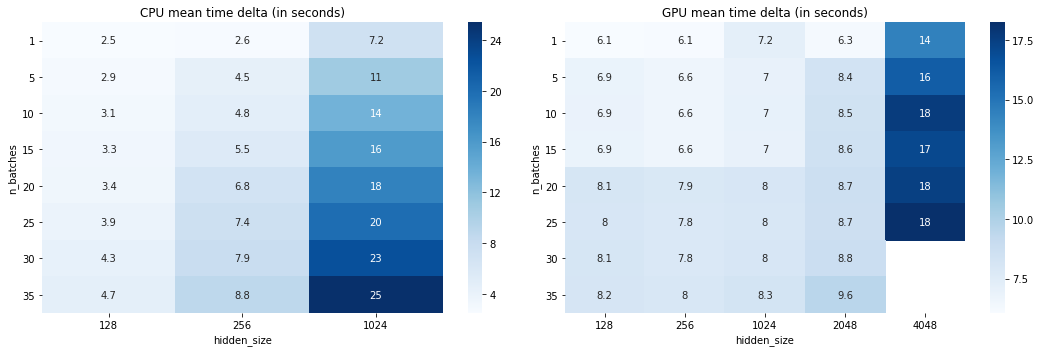

In [75]:
plt.figure(figsize=(15,5))
plt.subplot(121)
cds = res_ds[res_ds['device']=='CPU'].pivot_table(index='n_batches',columns='hidden_size', values='time_delta_seconds', aggfunc='mean')
sns.heatmap(cds, cmap='Blues', annot=True)
plt.title('CPU mean time delta (in seconds)')
plt.yticks(rotation=0)

plt.subplot(122)
cds = res_ds[res_ds['device']=='GPU'].pivot_table(index='n_batches',columns='hidden_size', values='time_delta_seconds', aggfunc='mean')
sns.heatmap(cds, cmap='Blues', annot=True)
plt.title('GPU mean time delta (in seconds)')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [193]:
res_ds.loc[0,'time_last']

0                          NaT
0   2019-06-21 13:26:54.462609
0   2019-06-21 13:31:19.785001
0   2019-06-21 13:43:23.235847
0   2019-06-21 13:48:10.223666
0   2019-06-21 13:55:45.209949
0   2019-06-21 14:14:03.734056
0   2019-06-21 14:19:15.313439
0   2019-06-21 14:27:16.090213
0   2019-06-21 14:49:53.208441
0   2019-06-21 15:00:01.170786
0   2019-06-21 15:10:14.561571
0   2019-06-21 15:22:17.434600
0   2019-06-21 15:33:45.552615
0   2019-06-21 15:44:51.541178
0   2019-06-21 15:56:34.850494
0   2019-06-21 16:08:05.462791
0   2019-06-21 16:19:11.602160
Name: time_last, dtype: datetime64[ns]

In [192]:
res_ds['time']-res_ds['time_last']

0                NaT
1    00:00:02.499547
2    00:00:02.488024
3    00:00:02.472182
4    00:00:02.465685
5    00:00:02.495107
6    00:00:02.511231
7    00:00:02.510834
8    00:00:02.518610
9    00:00:02.465370
10   00:00:02.539072
11   00:00:02.510707
12   00:00:02.536547
13   00:00:02.484916
14   00:00:02.474510
15   00:00:02.515962
16   00:00:02.482994
17   00:00:02.564232
18   00:00:02.503312
19   00:00:02.468693
20   00:00:02.499040
21   00:00:02.406645
22   00:00:02.449844
23   00:00:02.485846
24   00:00:02.488196
25   00:00:02.483074
26   00:00:02.483712
27   00:00:02.486886
28   00:00:02.497121
29   00:00:02.484158
           ...      
70   00:00:06.857428
71   00:00:06.952772
72   00:00:06.959109
73   00:00:07.129997
74   00:00:06.973950
75   00:00:07.053132
76   00:00:06.904074
77   00:00:06.987735
78   00:00:07.155760
79   00:00:07.056350
80   00:00:06.857657
81   00:00:06.995847
82   00:00:07.026163
83   00:00:07.009968
84   00:00:07.146672
85   00:00:07.119455
86   00:00:07

In [64]:
for epoch in range(start_epoch, n_epochs):
    _, loss = sess.run([gru.train_step, gru.loss],
                         feed_dict=feed_dict)
    gru_losses.append(loss)
    gru_times.append(datetime.now())

KeyboardInterrupt: 

In [156]:
topickle = {}

In [157]:
topickle['O1:0'] = sess.run(gru.O1)
topickle['O2:0'] = sess.run(gru.O2)
topickle['O3:0'] = sess.run(gru.O3)
topickle['O4:0'] = sess.run(gru.O4)
topickle['bO1:0'] = sess.run(gru.bO1)
topickle['bO2:0'] = sess.run(gru.bO2)
topickle['bO3:0'] = sess.run(gru.bO3)
topickle['bO4:0'] = sess.run(gru.bO4)
topickle['M_O1V:0'] = sess.run(gru.M_O1V)
topickle['M_O2V:0'] = sess.run(gru.M_O2V)
topickle['M_O3V:0'] = sess.run(gru.M_O3V)
topickle['M_O4V:0'] = sess.run(gru.M_O4V)
topickle['Ir:0'] = sess.run(gru.Ir)
topickle['Iu:0'] = sess.run(gru.Iu)
topickle['Ie:0'] = sess.run(gru.Ie)
topickle['Rr:0'] = sess.run(gru.Rr)
topickle['Ru:0'] = sess.run(gru.Ru)
topickle['Re:0'] = sess.run(gru.Re)
topickle['M_IrV:0'] = sess.run(gru.M_IrV)
topickle['M_IuV:0'] = sess.run(gru.M_IuV)
topickle['M_IeV:0'] = sess.run(gru.M_IeV)
topickle['M_RrV:0'] = sess.run(gru.M_RrV)
topickle['M_RuV:0'] = sess.run(gru.M_RuV)
topickle['M_ReV:0'] = sess.run(gru.M_ReV)
topickle['br:0'] = sess.run(gru.br)
topickle['bu:0'] = sess.run(gru.bu)
topickle['be:0'] = sess.run(gru.be)

In [142]:
import pickle

In [158]:
with open(DIRS['MODELS']+model_name+'/model_params.pickle', 'wb') as f:
    pickle.dump(topickle, f)

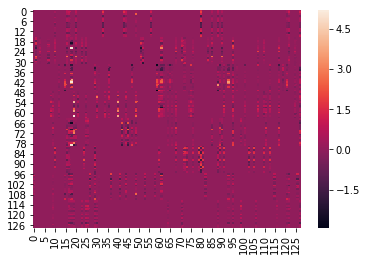

In [159]:
sns.heatmap(gru.O1.eval(session=sess))

In [ ]:
plt.plot(gru_losses)

In [ ]:
saver.save(sess, DIRS['MODELS']+model_name+'/final_',write_meta_graph=True)

In [ ]:
gener_audio = gru.generate_audio(txt_emb, sess, seconds=1, show_tqdm=True)

In [ ]:
audio_real = audio*128+128
audio_real = audio_real[:,0]*256+audio_real[:,1]

In [ ]:
t

In [ ]:
plt.plot(audio_real)

In [ ]:
gener_audio

In [ ]:
plt.plot(gener_audio)

In [ ]:
h_t = np.zeros((gru.n_batches, gru.hidden_size), dtype='float32')
x = np.zeros((gru.n_batches, 1, gru.input_dim), dtype='float32')

In [ ]:
x = audio_resh[:,0].reshape(gru.n_batches, 1, gru.input_dim-1)

In [ ]:
c = x[:,:,0]
c_shift = np.hstack([c, [[0]]*gru.n_batches])[:,1:]
c_shift = c_shift.reshape(gru.n_batches,-1,1)
x = np.concatenate([x, c_shift],2)

In [ ]:
xs = [x[:,:,:2]]

In [ ]:
n_iters = 10

In [ ]:
feed_dict={gru.sound_X:x, gru.h_0:h_t, gru.txt_embed_plh:txt_emb}

In [ ]:
c_t = sess.run(gru.c_t, feed_dict=feed_dict)

In [ ]:
c_t

In [ ]:

#for i in tqdm_notebook(range(n_iters), disable=not show_tqdm):
    c_t = session.run(self.c_t, feed_dict=feed_dict)
    x[:,0,2] = c_t[:,0,0]
    feed_dict={self.sound_X:x, self.h_0:h_t, self.txt_embed_plh:txt_emb}
    x, h_t = session.run([self.y, self.h_t_trans], feed_dict=feed_dict) 
    x = np.concatenate([x,np.zeros((self.n_batches,1,1))],2)
    h_t = h_t[0] #[1,n_batches,hidden_size] -> [n_batches, hidden_size]
    xs.append(x[:,:,:2])